# Different kinds of timeseries tasks

A timeseries can be any data obtained via measurements at regular intervals, like
the daily price of a stock, the hourly electricity consumption of a city, or the
weekly sales of a store. Timeseries are everywhere, whether we’re looking at natural phenomena (like seismic activity, the evolution of fish populations in a river,
or the weather at a location) or human activity patterns (like visitors to a website,
a country’s GDP, or credit card transactions). Unlike the types of data you’ve
encountered so far, working with timeseries involves understanding the dynamics
of a system—its periodic cycles, how it trends over time, its regular regime and its
sudden spikes.

# A temperature-forecasting example

Throughout this chapter, all of our code examples will target a single problem: predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the
recent past by a set of sensors on the roof of a building. As you will see, it’s a fairly challenging problem!

densely connected networks and convolutional networks aren’t well-equipped
to deal with this kind of dataset, while a different kind of machine learning technique—recurrent neural networks (RNNs)—really shines on this type of problem

Inspecting the data of the Jena weather dataset

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [6]:
print(len(lines))

420451


Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we
will use to predict future temperatures. Note that we discard the “Date Time” column.

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [2]:
import tensorflow as tf

# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using the GPU:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU found. TensorFlow is using the CPU.")
tf.debugging.set_log_device_placement(False)


TensorFlow is using the GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Plotting the temperature timeseries

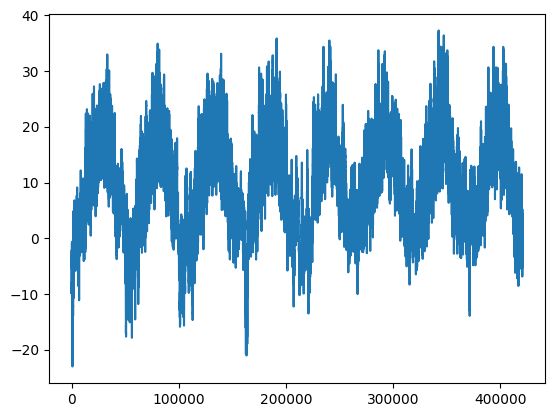

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

Plotting the first 10 days of the temperature timeseries

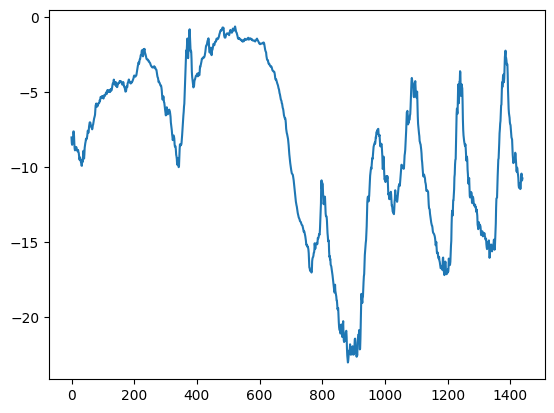

In [8]:
plt.plot(range(1440), temperature[:1440])

Always look for periodicity in your data
Periodicity over multiple timescales is an important and very common property of
timeseries data. Whether you’re looking at the weather, mall parking occupancy, traffic to a website, sales of a grocery store, or steps logged in a fitness tracker, you’ll
see daily cycles and yearly cycles (human-generated data also tends to feature
weekly cycles). When exploring your data, make sure to look for these patterns.

When working with timeseries
data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse,
and your validation/test splits should reflect that. Some problems happen to be considerably simpler if you reverse the time axis!

Computing the number of samples we’ll use for each data split

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Preparing the data

The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per
mole, is around 3). We’ll normalize each timeseries independently so that they all
take small values on a similar scale. We’re going to use the first 210,225 timesteps as
training data, so we’ll compute the mean and standard deviation only on this fraction of the data

Normalizing the data

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

we’ll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays, and nothing more.
We could easily write a Python generator to do this, but there’s a built-in dataset
utility in Keras that does just that (timeseries_dataset_from_array()), so we can
save ourselves some work by using it. You can generally use it for any kind of timeseries
forecasting task

if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then
timeseries_dataset_from_array() will generate the following samples: [0 1 2],
[1 2 3], [2 3 4], [3 4 5], [4 5 6].

with data = [0 1 2 3 4 5 6 …] and sequence_length=3, you could create
a dataset to predict the next step in the series by passing targets = [3 4 5 6 …]

Instantiating datasets for training, validation, and testing

In [7]:
from tensorflow import keras
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=0,
end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_train_samples,
end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_train_samples + num_val_samples)

Note that the samples are randomly
shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1])
aren’t necessarily temporally close.

Inspecting the output of one of our datasets

In [8]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## A common-sense, non-machine learning baseline

Computing the common-sense baseline MAE

The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the
input sequence. Recall that we normalized our features, so to retrieve a temperature in degrees Celsius,
we need to un-normalize it by multiplying it by the standard deviation and adding back the mean

In [9]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**Let’s try a basic machine learning model**

We use mean
squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth
around zero, which is a useful property for gradient descent. We will monitor MAE by
adding it as a metric in compile().

Training and evaluating a densely connected model

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_dense.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 14ms/step - loss: 13.2612 - mae: 2.8148 - val_loss: 10.6440 - val_mae: 2.5823
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 9.3680 - mae: 2.4132 - val_loss: 12.9415 - val_mae: 2.8655
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 8.6015 - mae: 2.3114 - val_loss: 15.9473 - val_mae: 3.2058
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 8.0954 - mae: 2.2404 - val_loss: 10.9119 - val_mae: 2.6321
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 7.7502 - mae: 2.1911 - val_loss: 12.6036 - val_mae: 2.8272
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 7.4778 - mae: 2.1508 - val_loss: 10.8124 - val_mae: 2.6214
Epoch 7/10
819/819 [==============================] - 21s 25ms/step - loss: 7.2307 - mae: 2.1162 - val_loss: 10.5465 - val_mae: 2.5924
Epoch 8/10
819/819 [==============================] - 

Plotting results

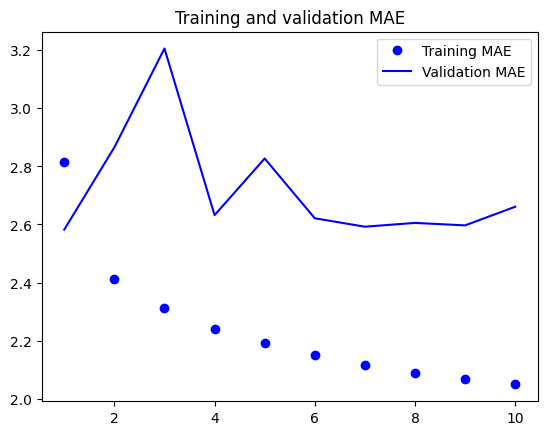

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

why doesn’t the model you’re training find it
and improve on it? Well, the space of models in which you’re searching for a solution—
that is, your hypothesis space—is the space of all possible two-layer networks with the
configuration you defined. The common-sense heuristic is just one model among millions that can be represented in this space. It’s like looking for a needle in a haystack.
Just because a good solution technically exists in your hypothesis space doesn’t mean
you’ll be able to find it via gradient descent.

That’s a pretty significant limitation of machine learning in general: unless the
learning algorithm is hardcoded to look for a specific kind of simple model, it can
sometimes fail to find a simple solution to a simple problem. That’s why leveraging
good feature engineering and relevant architecture priors is essential: you need to
precisely tell your model what it should be looking for.

----------------

A temporal convnet
could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.

Let’s try one on our temperature-forecasting problem. We’ll pick an initial window
length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via MaxPooling1D layers), we’ll reduce the window size accordingly

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_conv.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 17ms/step - loss: 23.8067 - mae: 3.8038 - val_loss: 17.4269 - val_mae: 3.3364
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 15.5288 - mae: 3.1133 - val_loss: 16.8624 - val_mae: 3.2344
Epoch 3/10
819/819 [==============================] - 26s 32ms/step - loss: 14.0416 - mae: 2.9631 - val_loss: 16.1162 - val_mae: 3.1894
Epoch 4/10
819/819 [==============================] - 28s 33ms/step - loss: 13.1569 - mae: 2.8678 - val_loss: 15.1938 - val_mae: 3.0866
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 12.4888 - mae: 2.7928 - val_loss: 17.1289 - val_mae: 3.2667
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 11.9690 - mae: 2.7353 - val_loss: 15.3079 - val_mae: 3.0793
Epoch 7/10
819/819 [==============================] - 24s 29ms/step - loss: 11.4457 - mae: 2.6719 - val_loss: 14.1974 - val_mae: 2.9536
Epoch 8/10
819/819 [============================

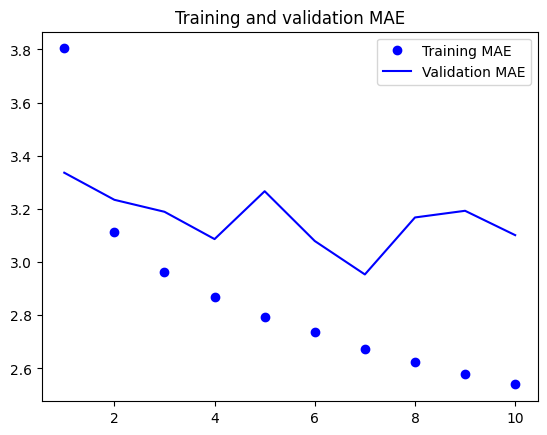

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

As it turns out, this model performs even worse than the densely connected one,
only achieving a validation MAE of about 2.9 degrees, far from the common-sense
baseline.

First, weather data doesn’t quite respect the translation invariance assumption.
While the data does feature daily cycles, data from a morning follows different
properties than data from an evening or from the middle of the night. Weather
data is only translation-invariant for a very specific timescale

Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A
1D convnet is not able to leverage this fact. In particular, our max pooling and
global average pooling layers are largely destroying order information.

**A first recurrent baseline**

Neither the fully connected approach nor the convolutional approach did well, but
that doesn’t mean machine learning isn’t applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time
from the input data. The convolutional approach treated every segment of the data in
the same way, even applying pooling, which destroyed order information. Let’s
instead look at the data as what it is: a sequence, where causality and order matter.

A simple LSTM-based model

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 58s 31ms/step - loss: 44.7574 - mae: 4.8923 - val_loss: 13.4300 - val_mae: 2.7757
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 11.1564 - mae: 2.5896 - val_loss: 9.5741 - val_mae: 2.4144
Epoch 3/10
819/819 [==============================] - 19s 23ms/step - loss: 9.7718 - mae: 2.4401 - val_loss: 9.4633 - val_mae: 2.3934
Epoch 4/10
819/819 [==============================] - 27s 32ms/step - loss: 9.3901 - mae: 2.3901 - val_loss: 9.2632 - val_mae: 2.3636
Epoch 5/10
819/819 [==============================] - 90s 110ms/step - loss: 9.1556 - mae: 2.3577 - val_loss: 9.3964 - val_mae: 2.3801
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 8.9753 - mae: 2.3333 - val_loss: 9.4651 - val_mae: 2.3962
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 8.8284 - mae: 2.3130 - val_loss: 9.5419 - val_mae: 2.4062
Epoch 8/10
819/819 [==============================] - 18s 

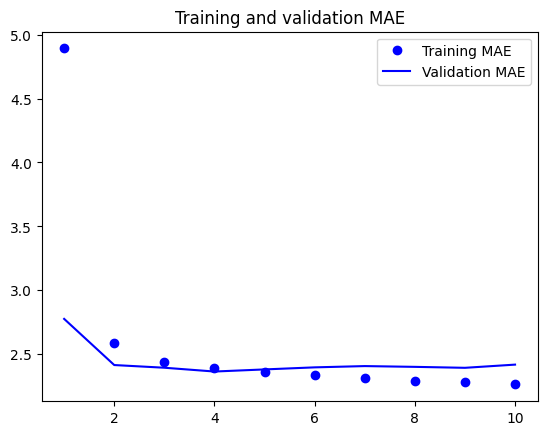

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The LSTM-based model can finally beat the
common-sense baseline (albeit just by a bit, for now), demonstrating the value of
machine learning on this task

Pseudocode RNN

In [ ]:
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

More-detailed pseudocode for the RNN

In [ ]:
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

NumPy implementation of a simple RNN

In [8]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In summary, an RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more. Of course, there are
many different RNNs fitting this definition that you could build—this example is one
of the simplest RNN formulations. RNNs are characterized by their step function

An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

All recurrent layers in Keras (SimpleRNN, LSTM, and GRU) can be run in two different modes: they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape (batch_size, timesteps, output_features)) or
return only the last output for each input sequence (a rank-2 tensor of shape (batch_
size, output_features)). These two modes are controlled by the return_sequences
constructor argument.

An RNN layer that returns only its last output step

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


An RNN layer that returns its full output sequence

In [5]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


Stacking RNN layers

In [6]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

the combination of operations making up an RNN cell is better interpreted as a set of constraints
on your search, not as a design in an engineering sense

he LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

# Advanced use of recurrent neural networks

## Using recurrent dropout to fight overfitting

Because networks being regularized with dropout always take much longer to fully converge, we’ll train the model for five times as many epochs.

Training and evaluating a dropout-regularized LSTM

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 1275s 2s/step - loss: 28.6257 - mae: 3.9460 - val_loss: 9.8258 - val_mae: 2.4385
Epoch 2/50
819/819 [==============================] - 1267s 2s/step - loss: 15.0897 - mae: 3.0152 - val_loss: 9.7006 - val_mae: 2.4262
Epoch 3/50
819/819 [==============================] - 683s 833ms/step - loss: 14.1679 - mae: 2.9166 - val_loss: 9.4016 - val_mae: 2.3752
Epoch 4/50
819/819 [==============================] - 288s 351ms/step - loss: 13.3763 - mae: 2.8338 - val_loss: 9.3861 - val_mae: 2.3815
Epoch 5/50
819/819 [==============================] - ETA: 0s - loss: 12.8977 - mae: 2.7825

KeyboardInterrupt: 

it’s generally a good idea to
increase the capacity of your model until overfitting becomes the primary obstacle
(assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren’t overfitting too badly, you’re likely under capacity.

Training and evaluating a dropout-regularized, stacked GRU mode

---------------

In [11]:
from tensorflow import keras
from keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 1103s 1s/step - loss: 24.8726 - mae: 3.6863 - val_loss: 9.2413 - val_mae: 2.3527
Epoch 2/50
819/819 [==============================] - 953s 1s/step - loss: 14.0167 - mae: 2.9000 - val_loss: 8.8419 - val_mae: 2.3012
Epoch 3/50
819/819 [==============================] - 642s 783ms/step - loss: 13.2893 - mae: 2.8250 - val_loss: 8.9345 - val_mae: 2.3319
Epoch 4/50
819/819 [==============================] - 1372s 2s/step - loss: 12.7526 - mae: 2.7655 - val_loss: 8.7958 - val_mae: 2.3000
Epoch 5/50
819/819 [==============================] - 2190s 3s/step - loss: 12.3000 - mae: 2.7202 - val_loss: 8.6488 - val_mae: 2.2781
Epoch 6/50
819/819 [==============================] - 900s 1s/step - loss: 11.7849 - mae: 2.6641 - val_loss: 8.9712 - val_mae: 2.3346
Epoch 7/50
 17/819 [..............................] - ETA: 15:45 - loss: 11.8051 - mae: 2.6655

KeyboardInterrupt: 

**A bidirectional RNN** is a common RNN variant that can offer greater performance than a regular
RNN on certain tasks. It’s frequently used in natural language processing

By processing a sequence
both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

The reversed-order LSTM strongly underperforms even the common-sense baseline,
indicating that in this case, chronological processing is important to the success of the
approach. 

Training and evaluating a dropout-regularized, stacked GRU model

In [ ]:
nputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

t looks at its input sequence both ways (see figure 10.14),
obtaining potentially richer representations and capturing patterns that may have
been missed by the chronological-order version alone.

Training and evaluating a bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset)

You’ll find that it doesn’t perform as well as the plain LSTM layer. It’s easy to understand why: all the predictive capacity must come from the chronological half of the
network, because the antichronological half is known to be severely underperforming
on this task

At the same time, the presence of the antichronological half doubles the
network’s capacity and causes it to start overfitting much earlier.

However, bidirectional RNNs are a great fit for text data, or any other kind of data
where order matters, yet where which order you use doesn’t matter. In fact, for a while
in 2016, bidirectional LSTMs were considered the state of the art on many natural language processing tasks (before the rise of the Transformer architecture, 

There are many other things you could try in order to improve performance on the
temperature-forecasting problem:
 Adjust the number of units in each recurrent layer in the stacked setup, as well
as the amount of dropout. The current choices are largely arbitrary and thus
probably suboptimal.
 Adjust the learning rate used by the RMSprop optimizer, or try a different
optimizer.
 Try using a stack of Dense layers as the regressor on top of the recurrent layer,
instead of a single Dense layer.
 Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.

There is currently no theory that will tell you in advance precisely what you should do to optimally
solve a problem. You must iterate

As you first learned in chapter 5, when approaching a new problem, it’s good to
first establish common-sense baselines for your metric of choice. If you don’t
have a baseline to beat, you can’t tell whether you’re making real progress.
 Try simple models before expensive ones, to make sure the additional expense
is justified. Sometimes a simple model will turn out to be your best option.
 When you have data where ordering matters, and in particular for timeseries
data, recurrent networks are a great fit and easily outperform models that first flatten the temporal data. The two essential RNN layers available in Keras are the
LSTM layer and the GRU layer.
 To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all you have to do is use the recurrent_dropout arguments of recurrent
layers.
 Stacked RNNs provide more representational power than a single RNN layer.
They’re also much more expensive and thus not always worth it. Although they
offer clear gains on complex problems (such as machine translation), they may
not always be relevant to smaller, simpler problems.